# Porównanie wszystkich modeli: Graph Transformers vs Baselines vs Hybrid

**Dataset: ogbg-molpcba** (Multi-label Classification, Average Precision)

Ten notebook porównuje wszystkie zaimplementowane modele na datasetcie ogbg-molpcba:

## Graph Transformers
1. **GOAT** - Global attention z virtual nodes (O(N))
2. **Exphormer** - Sparse attention z expander graphs (O(Nd))

## Baseline GNNs
3. **GCN** - Graph Convolutional Network (O(E))
4. **GAT** - Graph Attention Network (O(E))
5. **GIN** - Graph Isomorphism Network (O(E))
6. **GraphMLP** - MLP bez struktury grafu

## Modele Hybrydowe
7. **GCNVirtualNode** - GCN z Virtual Node (O(E+N))
8. **GINVirtualNode** - GIN z Virtual Node (O(E+N))

---

**Task**: Multi-label classification (128 binary classification tasks)
**Metric**: Average Precision (AP, higher is better)

In [12]:
# Setup - dodaj ścieżkę do projektu
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import hashlib
import json
import os
from pathlib import Path
warnings.filterwarnings('ignore')

from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

# Importuj wszystkie modele
from models import (
    GOAT, Exphormer,           # Graph Transformers
    GCN, GAT, GIN, GraphMLP,   # Baselines
    GCNVirtualNode, GINVirtualNode  # Hybrid
)

# Importuj utilities
from src.utils.data import (
    load_zinc_dataset, 
    load_molhiv_dataset, 
    load_molpcba_dataset
)
from src.utils.positional_encodings import precompute_positional_encodings
from src.utils.complexity import ComplexityTracker, count_parameters
from src.utils.metrics import compute_metrics

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
PyTorch version: 2.6.0+cu124
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.8 GB


## Konfiguracja eksperymentu

**Wybierz tryb:**
- `cpu` - szybki test (mały dataset, mało epok) - ~10-15 minut
- `gpu` - pełny eksperyment (cały dataset, więcej epok) - ~1-2 godziny

In [13]:
# ========================================================
# KONFIGURACJA - ZMIEŃ TUTAJ
# ========================================================

EXPERIMENT_MODE = "gpu"  # "cpu" lub "gpu"

# ========================================================

if EXPERIMENT_MODE == "cpu":
    # Tryb CPU - szybki test
    CONFIG = {
        'dataset': 'molpcba',
        'use_subset': True,
        'subset_size': 500,
        'batch_size': 32,
        'num_epochs': 10,
        'hidden_dim': 64,
        'num_layers': 3,
        'num_heads': 4,
        'lr': 1e-3,
        'dropout': 0.1,
        'pe_dim': 8,
        'device': 'cpu',
        # Early stopping
        'early_stopping': True,
        'patience': 5,
        'min_delta': 1e-5,
        # Model-specific hyperparameters
        'use_model_specific_lr': True,
        'weight_decay': 1e-5,
        'warmup_epochs': 0,  # Disable warmup for CPU mode
    }
    print("🖥️  TRYB CPU - Szybki test")
else:
    # Tryb GPU - pełny eksperyment
    # NOTE: MolPCBA is very large (438K graphs), so we use larger batch_size for efficiency
    CONFIG = {
        'dataset': 'molpcba',
        'use_subset': False,
        'subset_size': None,
        'batch_size': 128,  # Increased from 64 for MolPCBA (large dataset, ~350K train samples)
        'num_epochs': 200,  # Increased max epochs (early stopping will handle it)
        'hidden_dim': 256,
        'num_layers': 5,
        'num_heads': 8,
        'lr': 1e-4,
        'dropout': 0.1,
        'pe_dim': 16,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        # Early stopping
        'early_stopping': True,
        'patience': 20,  # Stop if no improvement for 20 epochs
        'min_delta': 1e-4,  # Minimum change to qualify as improvement (matches config files)
        # Model-specific hyperparameters
        'use_model_specific_lr': True,
        'weight_decay': 1e-5,
        'warmup_epochs': 5,  # Warmup for transformers (matches config files)
    }
    print("🚀 TRYB GPU - Pełny eksperyment")

print(f"\nKonfiguracja:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

🚀 TRYB GPU - Pełny eksperyment

Konfiguracja:
  dataset: molpcba
  use_subset: False
  subset_size: None
  batch_size: 128
  num_epochs: 200
  hidden_dim: 256
  num_layers: 5
  num_heads: 8
  lr: 0.0001
  dropout: 0.1
  pe_dim: 16
  device: cuda
  early_stopping: True
  patience: 20
  min_delta: 0.0001
  use_model_specific_lr: True
  weight_decay: 1e-05
  warmup_epochs: 5


## Ładowanie datasetu

In [14]:
def load_dataset_by_name(name, use_subset=False, subset_size=500, pe_dim=8):
    """Załaduj dataset po nazwie."""
    print(f"Ładowanie datasetu: {name}")
    
    if name == 'zinc':
        dataset, split_idx = load_zinc_dataset()
        task_type = 'regression'
        metric = 'mae'
        out_channels = 1
        in_channels = dataset[0].x.shape[1] if dataset[0].x.dim() > 1 else 1
    elif name == 'molhiv':
        dataset, split_idx = load_molhiv_dataset()
        task_type = 'binary_classification'
        metric = 'rocauc'
        out_channels = 1
        in_channels = dataset[0].x.shape[1]
    elif name == 'molpcba':
        dataset, split_idx = load_molpcba_dataset()
        task_type = 'multi_label'
        metric = 'ap'
        out_channels = 128  # 128 tasks
        in_channels = dataset[0].x.shape[1]
    else:
        raise ValueError(f"Nieznany dataset: {name}")
    
    # Użyj podzbioru jeśli potrzeba
    if use_subset:
        print(f"Używam podzbioru: {subset_size} grafów")
        indices = torch.randperm(len(dataset))[:subset_size]
        # Stwórz nowe splity
        train_size = int(0.8 * subset_size)
        val_size = int(0.1 * subset_size)
        split_idx = {
            'train': indices[:train_size],
            'valid': indices[train_size:train_size+val_size],
            'test': indices[train_size+val_size:],
        }
    
    # Precompute positional encodings
    print("Obliczam positional encodings...")
    dataset = precompute_positional_encodings(dataset, pe_type='laplacian', pe_dim=pe_dim)
    
    print(f"Dataset załadowany:")
    print(f"  Total: {len(dataset)} grafów")
    print(f"  Train: {len(split_idx['train'])}, Val: {len(split_idx['valid'])}, Test: {len(split_idx['test'])}")
    print(f"  In channels: {in_channels}, Out channels: {out_channels}")
    print(f"  Task type: {task_type}, Metric: {metric}")
    
    return dataset, split_idx, {
        'task_type': task_type,
        'metric': metric,
        'in_channels': in_channels,
        'out_channels': out_channels,
    }

# Załaduj dataset
dataset, split_idx, dataset_info = load_dataset_by_name(
    CONFIG['dataset'],
    use_subset=CONFIG['use_subset'],
    subset_size=CONFIG['subset_size'],
    pe_dim=CONFIG['pe_dim'],
)

Ładowanie datasetu: molpcba
Obliczam positional encodings...
Setting up laplacian positional encodings (dim=16)...
Precomputing encodings...
  Processed 100/437929 graphs
  Processed 200/437929 graphs
  Processed 300/437929 graphs
  Processed 400/437929 graphs
  Processed 500/437929 graphs
  Processed 600/437929 graphs
  Processed 700/437929 graphs
  Processed 800/437929 graphs
  Processed 900/437929 graphs
  Processed 1000/437929 graphs
  Processed 1100/437929 graphs
  Processed 1200/437929 graphs
  Processed 1300/437929 graphs
  Processed 1400/437929 graphs
  Processed 1500/437929 graphs
  Processed 1600/437929 graphs
  Processed 1700/437929 graphs
  Processed 1800/437929 graphs
  Processed 1900/437929 graphs
  Processed 2000/437929 graphs
  Processed 2100/437929 graphs
  Processed 2200/437929 graphs
  Processed 2300/437929 graphs
  Processed 2400/437929 graphs
  Processed 2500/437929 graphs
  Processed 2600/437929 graphs
  Processed 2700/437929 graphs
  Processed 2800/437929 graphs


In [15]:
# Stwórz DataLoadery
train_loader = DataLoader(
    dataset[split_idx['train']], 
    batch_size=CONFIG['batch_size'], 
    shuffle=True
)
val_loader = DataLoader(
    dataset[split_idx['valid']], 
    batch_size=CONFIG['batch_size'], 
    shuffle=False
)
test_loader = DataLoader(
    dataset[split_idx['test']], 
    batch_size=CONFIG['batch_size'], 
    shuffle=False
)

print(f"Batchy: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

Batchy: Train=2738, Val=343, Test=343


## Definicja modeli

In [16]:
def create_models(config, dataset_info):
    """Stwórz wszystkie modele do porównania."""
    in_ch = dataset_info['in_channels']
    out_ch = dataset_info['out_channels']
    hidden = config['hidden_dim']
    layers = config['num_layers']
    heads = config['num_heads']
    dropout = config['dropout']
    pe_dim = config['pe_dim']
    
    models = {
        # ===== Baselines =====
        'GCN': GCN(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        'GAT': GAT(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            num_heads=heads,
            dropout=dropout,
        ),
        'GIN': GIN(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        'GraphMLP': GraphMLP(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        
        # ===== Hybrid Models =====
        'GCN+VN': GCNVirtualNode(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        'GIN+VN': GINVirtualNode(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        
        # ===== Graph Transformers =====
        'GOAT': GOAT(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            num_heads=heads,
            pe_dim=pe_dim,
            dropout=dropout,
        ),
        'Exphormer': Exphormer(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            num_heads=heads,
            pe_dim=pe_dim,
            dropout=dropout,
        ),
    }
    
    return models

# Stwórz modele
models = create_models(CONFIG, dataset_info)

# Pokaż liczbę parametrów
print("\n" + "="*60)
print("MODELE I LICZBA PARAMETRÓW")
print("="*60)
for name, model in models.items():
    params = count_parameters(model)
    # count_parameters zwraca dict z kluczami: 'total', 'trainable', etc.
    print(f"{name:15s}: {params['total']:>10,} parametrów")
print("="*60)


MODELE I LICZBA PARAMETRÓW
GCN            :    366,976 parametrów
GAT            :    369,536 parametrów
GIN            :    960,645 parametrów
GraphMLP       :    298,624 parametrów
GCN+VN         :    963,460 parametrów
GIN+VN         :  1,557,129 parametrów
GOAT           :  5,043,584 parametrów
Exphormer      :  5,372,549 parametrów


## Funkcje treningowe

In [17]:
def train_epoch(model, loader, optimizer, device, task_type='regression'):
    """Trenuj przez jedną epokę."""
    model.train()
    total_loss = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        out = model(batch)
        
        # Oblicz loss w zależności od typu zadania
        if task_type == 'regression':
            y = batch.y.float().view(-1, 1)
            loss = F.mse_loss(out, y)
        elif task_type == 'binary_classification':
            y = batch.y.float().view(-1, 1)
            loss = F.binary_cross_entropy_with_logits(out, y)
        elif task_type == 'multi_label':
            y = batch.y.float()
            # Ignoruj NaN labels
            mask = ~torch.isnan(y)
            loss = F.binary_cross_entropy_with_logits(out[mask], y[mask])
        else:
            raise ValueError(f"Unknown task type: {task_type}")
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item() * batch.num_graphs
    
    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, device, task_type='regression', metric='mae'):
    """Ewaluuj model."""
    model.eval()
    
    all_preds = []
    all_labels = []
    total_loss = 0
    
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        
        if task_type == 'regression':
            y = batch.y.float().view(-1, 1)
            loss = F.mse_loss(out, y)
            all_preds.append(out.cpu())
            all_labels.append(y.cpu())
        elif task_type == 'binary_classification':
            y = batch.y.float().view(-1, 1)
            loss = F.binary_cross_entropy_with_logits(out, y)
            all_preds.append(torch.sigmoid(out).cpu())
            all_labels.append(y.cpu())
        elif task_type == 'multi_label':
            y = batch.y.float()
            mask = ~torch.isnan(y)
            loss = F.binary_cross_entropy_with_logits(out[mask], y[mask])
            all_preds.append(torch.sigmoid(out).cpu())
            all_labels.append(y.cpu())
        
        total_loss += loss.item() * batch.num_graphs
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Oblicz metrykę
    if metric == 'mae':
        score = F.l1_loss(all_preds, all_labels).item()
    elif metric == 'rocauc':
        from sklearn.metrics import roc_auc_score
        try:
            score = roc_auc_score(all_labels.numpy(), all_preds.numpy())
        except:
            score = 0.5
    elif metric == 'ap':
        from sklearn.metrics import average_precision_score
        mask = ~torch.isnan(all_labels)
        try:
            score = average_precision_score(all_labels[mask].numpy(), all_preds[mask].numpy())
        except:
            score = 0.0
    else:
        score = total_loss / len(loader.dataset)
    
    return score, total_loss / len(loader.dataset)


def get_model_specific_config(model_name, base_config):
    """Zwróć model-specific konfigurację hiperparametrów."""
    config = base_config.copy()
    
    # Model-specific learning rates (based on proven configs)
    if base_config.get('use_model_specific_lr', False):
        if model_name == 'GOAT':
            # GOAT: 5e-4 (from configs/goat_zinc.yaml)
            config['lr'] = base_config['lr'] * 5.0  # 5e-4 dla GOAT
        elif model_name == 'Exphormer':
            # Exphormer: 3e-4 (lowered from 5e-4 due to training instability)
            config['lr'] = base_config['lr'] * 3.0  # 3e-4 dla Exphormer (more stable)
        elif model_name in ['GIN', 'GIN+VN']:
            # GIN: 1e-3 (from configs/gin_zinc.yaml)
            config['lr'] = base_config['lr'] * 10.0  # 1e-3 dla GIN
        elif model_name in ['GCN+VN']:
            # GCN+VN: 1e-3 (from configs/gcn_virtualnode_zinc.yaml)
            config['lr'] = base_config['lr'] * 10.0  # 1e-3 dla GCN+VN
        # Inne modele używają base LR (1e-4)
    
    # Weight decay
    config['weight_decay'] = base_config.get('weight_decay', 0.0)
    
    # Warmup epochs (tylko dla transformers)
    if model_name in ['GOAT', 'Exphormer']:
        config['warmup_epochs'] = base_config.get('warmup_epochs', 0)
    else:
        config['warmup_epochs'] = 0
    
    return config


def get_config_hash(config, model_name, dataset_info):
    """Generate a hash for the configuration to identify checkpoints."""
    # Get model-specific config to compute actual LR and warmup
    model_config = get_model_specific_config(model_name, config)
    
    # Create a dict with relevant config keys
    config_dict = {
        'model_name': model_name,
        'dataset': config.get('dataset', ''),  # Dataset name (e.g., 'zinc', 'molhiv', 'molpcba')
        'batch_size': config.get('batch_size', 0),
        'num_epochs': config.get('num_epochs', 0),
        'hidden_dim': config.get('hidden_dim', 0),
        'num_layers': config.get('num_layers', 0),
        'num_heads': config.get('num_heads', 0),
        'lr': model_config.get('lr', 0),
        'dropout': config.get('dropout', 0),
        'pe_dim': config.get('pe_dim', 0),
        'weight_decay': model_config.get('weight_decay', 0),
        'warmup_epochs': model_config.get('warmup_epochs', 0),
        'early_stopping': config.get('early_stopping', False),
        'patience': config.get('patience', 0),
        'min_delta': config.get('min_delta', 0),
        'task_type': dataset_info.get('task_type', ''),
        'metric': dataset_info.get('metric', ''),
    }
    
    # Create hash
    config_str = json.dumps(config_dict, sort_keys=True, default=str)
    return hashlib.md5(config_str.encode()).hexdigest()[:12]


def save_checkpoint(model, optimizer, config_hash, model_name, best_val_score, best_epoch, history, train_time=0.0, checkpoint_dir='checkpoints'):
    """Save model checkpoint (includes train_time so it can be restored when loading)."""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True)
    
    checkpoint_path = checkpoint_dir / f"{model_name}_{config_hash}.pt"
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_score': best_val_score,
        'best_epoch': best_epoch,
        'history': history,
        'train_time': train_time,
        'config_hash': config_hash,
        'model_name': model_name,
    }, checkpoint_path)
    
    return checkpoint_path


def load_checkpoint(model, optimizer, config_hash, model_name, checkpoint_dir='checkpoints', device='cuda'):
    """Load model checkpoint if it exists."""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_path = checkpoint_dir / f"{model_name}_{config_hash}.pt"
    
    if not checkpoint_path.exists():
        return None
    
    # Use weights_only=False for trusted checkpoints (PyTorch 2.6+ default changed)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return {
        'best_val_score': checkpoint['best_val_score'],
        'best_epoch': checkpoint['best_epoch'],
        'history': checkpoint['history'],
        'train_time': checkpoint.get('train_time', 0.0),  # older checkpoints may not have it
    }


def train_model(model, train_loader, val_loader, config, dataset_info, model_name='', verbose=True, checkpoint_dir='checkpoints'):
    """Pełny trening modelu z early stopping i model-specific hyperparameters."""
    device = torch.device(config['device'])
    model = model.to(device)
    
    # Get model-specific config
    model_config = get_model_specific_config(model_name, config)
    lr = model_config['lr']
    weight_decay = model_config['weight_decay']
    warmup_epochs = model_config['warmup_epochs']
    
    # Generate config hash for checkpointing
    config_hash = get_config_hash(config, model_name, dataset_info)
    
    # Optimizer with weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Try to load checkpoint
    checkpoint_data = load_checkpoint(model, optimizer, config_hash, model_name, checkpoint_dir, device)
    if checkpoint_data is not None:
        if verbose:
            print(f"📂 Loaded checkpoint: {model_name} (config hash: {config_hash})")
            print(f"   Best val score: {checkpoint_data['best_val_score']:.4f} at epoch {checkpoint_data['best_epoch']}")
        return {
            'best_val_score': checkpoint_data['best_val_score'],
            'best_epoch': checkpoint_data['best_epoch'],
            'total_epochs': checkpoint_data['best_epoch'],
            'history': checkpoint_data['history'],
            'train_time': checkpoint_data.get('train_time', 0.0),  # read from checkpoint if saved
            'early_stopped': False,
            'loaded_from_checkpoint': True,
        }
    
    # Scheduler with warmup
    if warmup_epochs > 0:
        # Warmup + CosineAnnealingLR
        def lr_lambda(epoch):
            if epoch < warmup_epochs:
                # Linear warmup
                return (epoch + 1) / warmup_epochs
            else:
                # Cosine annealing after warmup
                progress = (epoch - warmup_epochs) / (config['num_epochs'] - warmup_epochs)
                return 0.5 * (1 + np.cos(np.pi * progress))
        
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    else:
        # Standard CosineAnnealingLR
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config['num_epochs']
        )
    
    task_type = dataset_info['task_type']
    metric = dataset_info['metric']
    
    # Czy wyższy wynik jest lepszy?
    higher_is_better = metric in ['rocauc', 'ap', 'accuracy']
    
    best_val_score = float('-inf') if higher_is_better else float('inf')
    history = {'train_loss': [], 'val_score': [], 'lr': []}
    best_model_state = None  # Store best model state
    
    # Early stopping
    early_stopping = config.get('early_stopping', False)
    patience = config.get('patience', 20)
    min_delta = config.get('min_delta', 1e-5)
    patience_counter = 0
    best_epoch = 0
    
    # Tracking czasu
    start_time = time.time()
    
    pbar = tqdm(range(config['num_epochs']), disable=not verbose)
    for epoch in pbar:
        train_loss = train_epoch(model, train_loader, optimizer, device, task_type)
        val_score, val_loss = evaluate(model, val_loader, device, task_type, metric)
        
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['val_score'].append(val_score)
        history['lr'].append(current_lr)
        
        # Check for improvement
        improved = False
        if higher_is_better:
            if val_score > best_val_score + min_delta:
                best_val_score = val_score
                best_epoch = epoch
                improved = True
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            if val_score < best_val_score - min_delta:
                best_val_score = val_score
                best_epoch = epoch
                improved = True
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        if not improved:
            patience_counter += 1
        
        # Early stopping check
        if early_stopping and patience_counter >= patience:
            if verbose:
                pbar.write(f"⏹️  Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                pbar.write(f"   Best score: {best_val_score:.4f} at epoch {best_epoch+1}")
            break
        
        pbar.set_postfix({
            'loss': f'{train_loss:.4f}',
            f'val_{metric}': f'{val_score:.4f}',
            f'best': f'{best_val_score:.4f}',
            'patience': f'{patience_counter}/{patience}',
            'lr': f'{current_lr:.2e}'
        })
    
    train_time = time.time() - start_time
    
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        model = model.to(device)
    
    # Save checkpoint (include train_time so it can be restored when loading)
    checkpoint_path = save_checkpoint(
        model, optimizer, config_hash, model_name, 
        best_val_score, best_epoch + 1, history, train_time, checkpoint_dir
    )
    if verbose:
        print(f"💾 Checkpoint saved: {checkpoint_path}")
    
    return {
        'best_val_score': best_val_score,
        'best_epoch': best_epoch + 1,
        'total_epochs': epoch + 1,
        'history': history,
        'train_time': train_time,
        'early_stopped': early_stopping and patience_counter >= patience,
        'loaded_from_checkpoint': False,
        'checkpoint_path': str(checkpoint_path),
    }

## Trening wszystkich modeli

In [18]:
# Trenuj wszystkie modele
results = {}

print("="*70)
print("TRENING WSZYSTKICH MODELI")
print("="*70)

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Trenuję: {name}")
    print(f"{'='*70}")
    
    # Reset modelu (świeże wagi)
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    
    # Mierz pamięć
    if torch.cuda.is_available() and CONFIG['device'] == 'cuda':
        torch.cuda.reset_peak_memory_stats()
    
    # Trenuj (with checkpointing)
    result = train_model(
        model, 
        train_loader, 
        val_loader, 
        CONFIG, 
        dataset_info,
        model_name=name,  # Pass model name for model-specific config
        verbose=True,
        checkpoint_dir='checkpoints'  # Checkpoint directory
    )
    
    # Zapisz wyniki
    result['params'] = count_parameters(model)['total']
    if torch.cuda.is_available() and CONFIG['device'] == 'cuda':
        result['peak_memory_mb'] = torch.cuda.max_memory_allocated() / 1e6
    else:
        result['peak_memory_mb'] = 0
    
    results[name] = result
    
    early_stop_info = f" (early stopped at epoch {result.get('total_epochs', '?')})" if result.get('early_stopped', False) else ""
    checkpoint_info = " [LOADED FROM CHECKPOINT]" if result.get('loaded_from_checkpoint', False) else ""
    print(f"\n✓ {name}: Best val {dataset_info['metric']} = {result['best_val_score']:.4f} at epoch {result.get('best_epoch', '?')}{early_stop_info}{checkpoint_info}")
    if not result.get('loaded_from_checkpoint', False):
        print(f"  Czas: {result['train_time']:.1f}s, Parametry: {result['params']:,}")
    else:
        print(f"  Parametry: {result['params']:,} (skipped training - loaded from checkpoint)")

print("\n" + "="*70)
print("TRENING ZAKOŃCZONY")
print("="*70)

TRENING WSZYSTKICH MODELI

Trenuję: GCN
📂 Loaded checkpoint: GCN (config hash: 65272eee57fc)
   Best val score: 0.4776 at epoch 185

✓ GCN: Best val ap = 0.4776 at epoch 185 [LOADED FROM CHECKPOINT]
  Parametry: 366,976 (skipped training - loaded from checkpoint)

Trenuję: GAT
📂 Loaded checkpoint: GAT (config hash: e18605fb422b)
   Best val score: 0.4291 at epoch 168

✓ GAT: Best val ap = 0.4291 at epoch 168 [LOADED FROM CHECKPOINT]
  Parametry: 369,536 (skipped training - loaded from checkpoint)

Trenuję: GIN
📂 Loaded checkpoint: GIN (config hash: 0458e962cc8f)
   Best val score: 0.4839 at epoch 197

✓ GIN: Best val ap = 0.4839 at epoch 197 [LOADED FROM CHECKPOINT]
  Parametry: 960,645 (skipped training - loaded from checkpoint)

Trenuję: GraphMLP
📂 Loaded checkpoint: GraphMLP (config hash: 318f6e9ee027)
   Best val score: 0.2510 at epoch 149

✓ GraphMLP: Best val ap = 0.2510 at epoch 149 [LOADED FROM CHECKPOINT]
  Parametry: 298,624 (skipped training - loaded from checkpoint)

Trenuj

## Podsumowanie wyników

In [19]:
# Tabela wyników
import pandas as pd
import json
from pathlib import Path

# Uzupełnij train_time i peak_memory_mb z zapisanego JSON, jeśli w pamięci jest 0 (np. po wczytaniu z checkpointu)
results_filename = Path(f"results_{CONFIG['dataset']}_{EXPERIMENT_MODE}.json")
if results_filename.exists():
    with open(results_filename) as f:
        saved = json.load(f)
    file_results = saved.get('results', saved) if 'results' in saved else saved
    for name in results:
        if name in file_results and isinstance(file_results[name], dict):
            if results[name].get('train_time', 0) == 0 and file_results[name].get('train_time', 0) != 0:
                results[name]['train_time'] = file_results[name]['train_time']
            if results[name].get('peak_memory_mb', 0) == 0 and file_results[name].get('peak_memory_mb', 0) != 0:
                results[name]['peak_memory_mb'] = file_results[name]['peak_memory_mb']

metric = dataset_info['metric']
higher_is_better = metric in ['rocauc', 'ap', 'accuracy']

summary = []
for name, res in results.items():
    summary.append({
        'Model': name,
        f'Val {metric.upper()}': res['best_val_score'],
        'Parametry': res['params'],
        'Czas (s)': res['train_time'],
        'Pamięć (MB)': res['peak_memory_mb'],
    })

df = pd.DataFrame(summary)

# Sortuj według metryki
df = df.sort_values(f'Val {metric.upper()}', ascending=not higher_is_better)

print("\n" + "="*80)
print(f"PODSUMOWANIE WYNIKÓW - Dataset: {CONFIG['dataset'].upper()}")
print("="*80)
print(df.to_string(index=False))
print("="*80)


PODSUMOWANIE WYNIKÓW - Dataset: MOLPCBA
    Model   Val AP  Parametry  Czas (s)  Pamięć (MB)
      GIN 0.483911     960645       0.0    36.310528
      GCN 0.477590     366976       0.0    22.948864
      GAT 0.429090     369536       0.0    24.475648
Exphormer 0.426845    5372549       0.0   141.462016
     GOAT 0.418146    5043584       0.0   113.369600
   GCN+VN 0.339960     963460       0.0    39.532032
   GIN+VN 0.328128    1557129       0.0    53.811200
 GraphMLP 0.250951     298624       0.0    28.665856


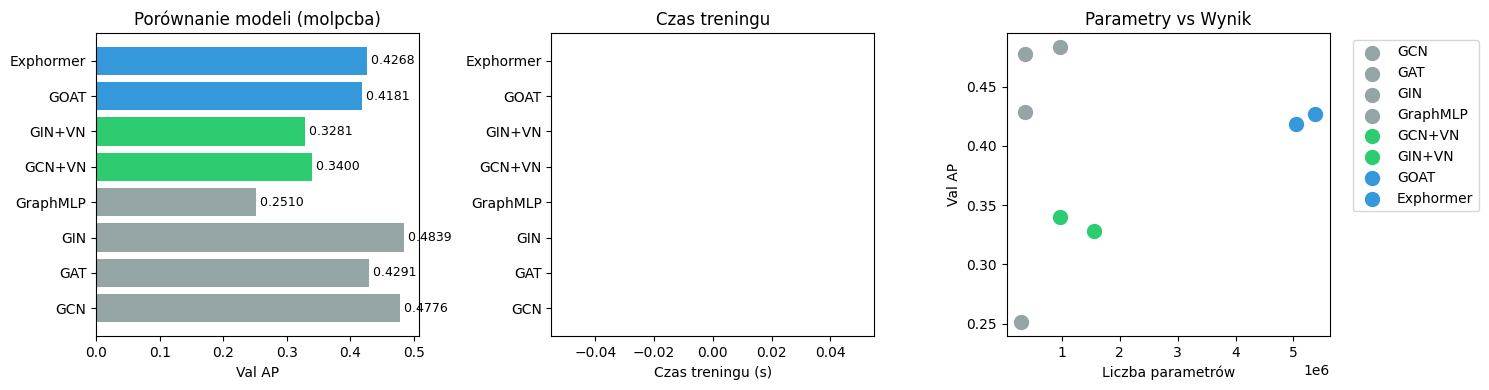


Wykres zapisany: model_comparison.png


In [20]:
# Wykresy
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Porównanie metryk
ax = axes[0]
names = list(results.keys())
scores = [results[n]['best_val_score'] for n in names]
colors = ['#2ecc71' if 'VN' in n else '#3498db' if n in ['GOAT', 'Exphormer'] else '#95a5a6' for n in names]
bars = ax.barh(names, scores, color=colors)
ax.set_xlabel(f'Val {metric.upper()}')
ax.set_title(f'Porównanie modeli ({CONFIG["dataset"]})')
for bar, score in zip(bars, scores):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
            f' {score:.4f}', va='center', fontsize=9)

# 2. Czas treningu
ax = axes[1]
times = [results[n]['train_time'] for n in names]
ax.barh(names, times, color=colors)
ax.set_xlabel('Czas treningu (s)')
ax.set_title('Czas treningu')

# 3. Parametry vs Wynik
ax = axes[2]
params = [results[n]['params'] for n in names]
for i, name in enumerate(names):
    ax.scatter(params[i], scores[i], s=100, c=colors[i], label=name)
ax.set_xlabel('Liczba parametrów')
ax.set_ylabel(f'Val {metric.upper()}')
ax.set_title('Parametry vs Wynik')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nWykres zapisany: model_comparison.png")

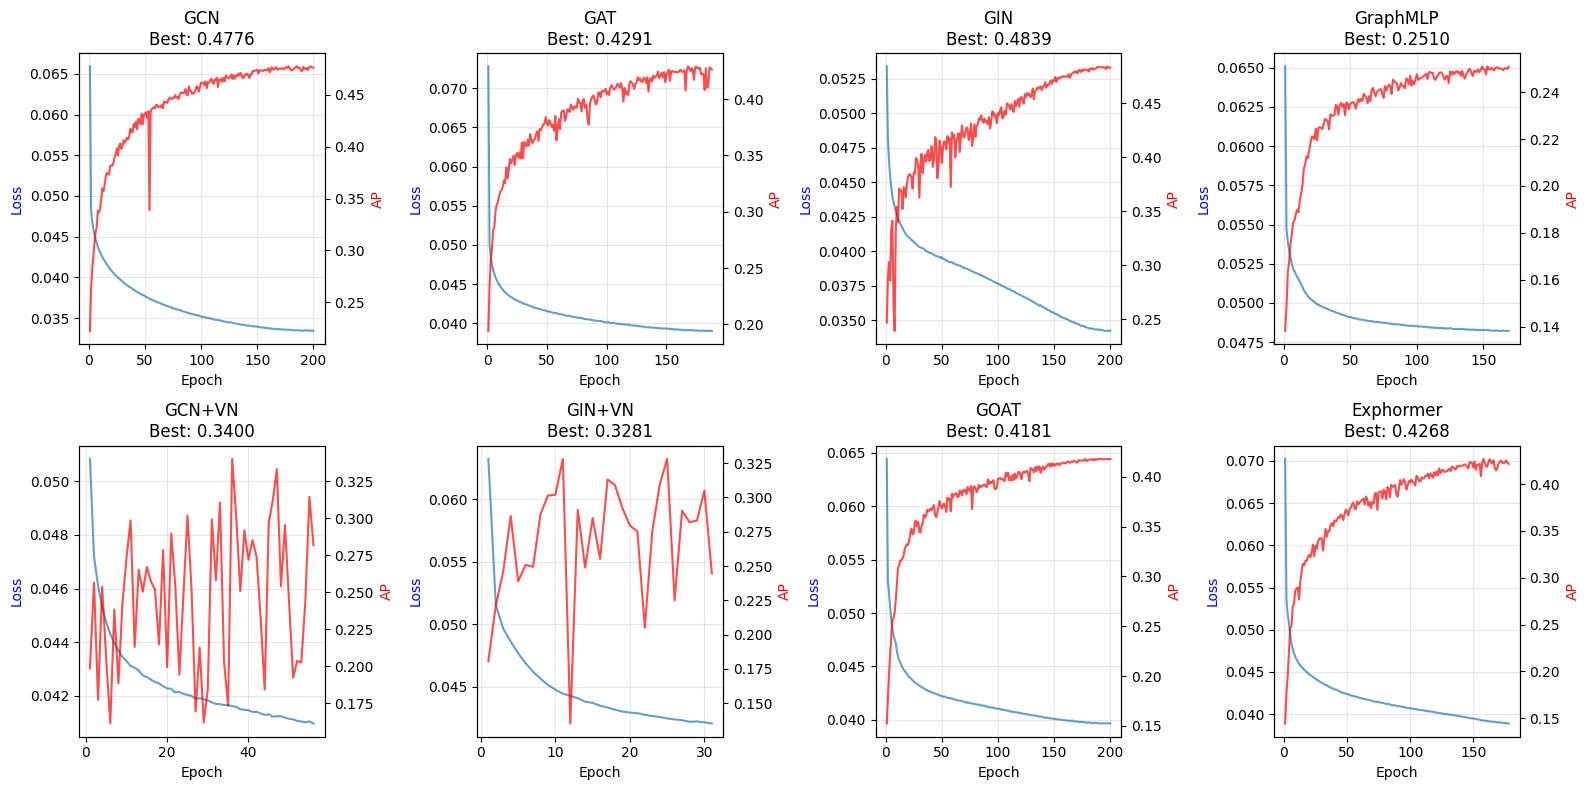


Wykres zapisany: learning_curves.png


In [21]:
# Krzywe uczenia
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    if idx >= len(axes):
        break
    ax = axes[idx]
    epochs = range(1, len(res['history']['train_loss']) + 1)
    
    ax.plot(epochs, res['history']['train_loss'], label='Train Loss', alpha=0.7)
    ax2 = ax.twinx()
    ax2.plot(epochs, res['history']['val_score'], 'r-', label=f'Val {metric}', alpha=0.7)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss', color='b')
    ax2.set_ylabel(f'{metric.upper()}', color='r')
    ax.set_title(f'{name}\nBest: {res["best_val_score"]:.4f}')
    ax.grid(True, alpha=0.3)

# Ukryj puste subploty
for idx in range(len(results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nWykres zapisany: learning_curves.png")

## Wnioski

Po uruchomieniu eksperymentu, wypełnij wnioski:

1. **Najlepszy model:** `[TUTAJ]`
2. **Czy modele hybrydowe (VN) poprawiają wyniki?** `[TAK/NIE]`
3. **Czy Graph Transformers są lepsze od GNN?** `[TAK/NIE/ZALEŻY]`
4. **Trade-off czas/jakość:** `[OPIS]`

In [22]:
# Zapisz wyniki do pliku
import json

# Przygotuj wyniki do zapisu
save_results = {}
for name, res in results.items():
    save_results[name] = {
        'best_val_score': float(res['best_val_score']),
        'params': res['params'],
        'train_time': res['train_time'],
        'peak_memory_mb': res['peak_memory_mb'],
    }

output = {
    'config': CONFIG,
    'dataset_info': dataset_info,
    'results': save_results,
}

filename = f"results_{CONFIG['dataset']}_{EXPERIMENT_MODE}.json"
with open(filename, 'w') as f:
    json.dump(output, f, indent=2)

print(f"Wyniki zapisane do: {filename}")

Wyniki zapisane do: results_molpcba_gpu.json
